In [1]:
import numpy as np
import tensorflow as tf
import prettytensor as pt

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook

import time, os, random
from datetime import timedelta

! killall tensorboard
os.system("tensorboard --logdir=/tmp/tboard --port=7007 &");
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"

/home/denis/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Load

In [2]:
X = np.load('data/X.npy')
y = np.load('data/y.npy')

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42, shuffle=True)
del X,y
temp = y_train.shape
y_train = y_train.reshape(temp[0], 1)
y_train = np.concatenate((1-y_train, y_train), axis=1)
temp = y_test.shape
y_test = y_test.reshape(temp[0], 1)
y_test = np.concatenate((1-y_test, y_test), axis=1)

## Params

In [4]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(X_train)))
print("- Test-set:\t\t{}".format(len(X_test)))

Size of:
- Training-set:		178142
- Test-set:		95923


In [5]:
# Size of image
img_size_h, img_size_w = 58, 40

# Images are stored in one-dimensional arrays of this length.
num_input = img_size_h * img_size_w

# Training Parameters
learning_rate = 0.001
train_batch_size = 256

# Network Parameters
num_channels = 3
num_classes = 2

# Flat size
img_size_flat = img_size_h * img_size_w * num_channels

## Ploting

In [6]:
def plot_images(images, cls_true, cls_pred=None):
    
    if len(images) == 0:
        print("no images to show")
        return 
    else:
        random_indices = random.sample(range(len(images)), min(len(images), 9))
        
        
    images, cls_true  = zip(*[(images[i], cls_true[i]) for i in random_indices])
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_size_h, img_size_w, num_channels))

        # Show true and predicted classes.
        if cls_pred is None:
            if len(cls_true[0]) == 2:
                xlabel = "True: {0}".format(cls_true[i][1])
            else:
                xlabel = "True: {0}".format(cls_true[i])
        else:
            if len(cls_true[0]) == 2:
                xlabel = "True: {0}, Pred: {1}".format(cls_true[i][1], cls_pred[i])
            else:
                xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Check

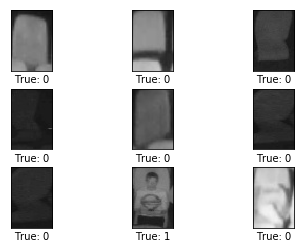

In [7]:
# Plot the images and labels using our helper-function above.
plot_images(images=X_test, cls_true=y_test)

## Tensorflow setup and run

### Placeholder variables

In [8]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, img_size_h, img_size_w, num_channels])

y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)

### Prettytensor layers

In [9]:
# Convolutional Layer 1.
filter_size1 = 3 
num_filters1 = 32

# Convolutional Layer 2.
filter_size2 = 3
num_filters2 = 32

# Convolutional Layer 3.
filter_size3 = 3
num_filters3 = 64

# Fully-connected layer.
fc_size = 128

In [10]:
x_pretty = pt.wrap(x_image)

with pt.defaults_scope(activation_fn=tf.nn.relu):
    y_pred, cost = x_pretty.\
        conv2d(kernel=filter_size1, depth=num_filters1, name='layer_conv1').\
        max_pool(kernel=2, stride=2).\
        conv2d(kernel=filter_size2, depth=num_filters2, name='layer_conv2').\
        max_pool(kernel=2, stride=2).\
        conv2d(kernel=filter_size3, depth=num_filters3, name='layer_conv3').\
        max_pool(kernel=2, stride=2).\
        flatten().\
        fully_connected(size=img_size_flat, name='layer_fc1').\
        fully_connected(size=fc_size, name='layer_fc2').\
        softmax_classifier(num_classes=num_classes, labels=y_true)

### Getting the Weights

In [11]:
def get_weights_variable(layer_name):
    # Retrieve an existing variable named 'weights' in the scope
    # with the given layer_name.
    # This is awkward because the TensorFlow function was
    # really intended for another purpose.

    with tf.variable_scope(layer_name, reuse=True):
        variable = tf.get_variable('weights')

    return variable

In [12]:
weights_conv1 = get_weights_variable(layer_name='layer_conv1')
weights_conv2 = get_weights_variable(layer_name='layer_conv2')
weights_conv3 = get_weights_variable(layer_name='layer_conv3')

### Optimization Method and performance measures

In [13]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

y_pred_cls = tf.argmax(y_pred, axis=1)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Run

In [14]:
session = tf.Session()
session.run(tf.global_variables_initializer())

#### Helper functions

In [15]:
def make_batch(x, y, batch_size):
    rand_index = np.random.choice(x.shape[0], size=batch_size)
    x_batch, y_batch = x[rand_index], y[rand_index]
    # Do all your pre-processing here
    # ...
    return (x_batch, y_batch)

In [16]:
def print_progress(epoch, feed_dict_train, feed_dict_validate, val_loss):
    # Calculate the accuracy on the training-set.
    acc = session.run(accuracy, feed_dict=feed_dict_train)
    val_acc = session.run(accuracy, feed_dict=feed_dict_validate)
    msg = "Epoch {0} --- Training Accuracy: {1:>6.1%}, Validation Accuracy: {2:>6.1%}, Validation Loss: {3:.3f}"
    print(msg.format(epoch + 1, acc, val_acc, val_loss))

def optimize(num_iterations, early_stopping = None):

    # Start-time used for printing time-usage below.
    start_time = time.time()
    
    best_val_loss = float("inf")
    patience = 0

    for i in range(0, num_iterations):

        # Get a batch of training examples.
        x_batch, y_true_batch = make_batch(X_train, y_train, train_batch_size)
        x_valid_batch, y_valid_batch = make_batch(X_test, y_test, train_batch_size)
        
        # Convert shape from [num examples, rows, columns, depth]
        # to [num examples, flattened image shape]

        x_batch = x_batch.reshape(train_batch_size, img_size_flat)
        x_valid_batch = x_valid_batch.reshape(train_batch_size, img_size_flat)

        # Put the batch into a dict for placeholder variables in the TensorFlow graph.
        # Train and validate
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}
        
        feed_dict_validate = {x: x_valid_batch,
                              y_true: y_valid_batch}

        # Run the optimizer using this batch of training data.
        session.run(optimizer, feed_dict=feed_dict_train)
        
        # Print status at end of each epoch (defined as full pass through training dataset).
        if i % int(len(X_train)/train_batch_size) == 0: 
            val_loss = session.run(cost, feed_dict=feed_dict_validate)
            epoch = int(i / int(len(X_train)/train_batch_size))
            
            print_progress(epoch, feed_dict_train, feed_dict_validate, val_loss)
            
            if early_stopping:    
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience = 0
                else:
                    patience += 1

                if patience == early_stopping:
                    break

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time elapsed: " + str(timedelta(seconds=int(round(time_dif)))))

In [17]:
def plot_example_errors(cls_pred, correct):
    
    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = X_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = y_test[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images,
                cls_true=cls_true,
                cls_pred=cls_pred)

def plot_confusion_matrix(cls_pred):

    # Get the true classifications for the test-set.
    cls_true = [y_test[i][1] for i in range(len(y_test))]
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true, y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.show()

def print_validation_accuracy(show_example_errors=False, show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(X_test)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    for i in tqdm_notebook(range(0, num_test-train_batch_size, train_batch_size)):
        j= i+train_batch_size
        
        # Get the images from the test-set between index i and j.
        images = X_test[i:j, :].reshape(train_batch_size, img_size_flat)
        
        # Get the associated labels.
        labels = y_test[i:j, :]
        
        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}
        
        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

    # Reshape test to one-dimensional
    cls_true = np.array([y_test[i][1] for i in range(len(y_test))])
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    correct_sum = correct.sum()
    
    # Calculate accuracy
    acc = accuracy_score(cls_true, cls_pred)
    
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

### Performance and accuracy with num_iterations=9000

Epoch 1 --- Training Accuracy:  81.2%, Validation Accuracy:  80.9%, Validation Loss: 2819.027
Epoch 2 --- Training Accuracy:  98.0%, Validation Accuracy:  99.6%, Validation Loss: 0.008
Epoch 3 --- Training Accuracy:  99.2%, Validation Accuracy:  98.8%, Validation Loss: 0.087
Time elapsed: 0:01:02


HBox(children=(IntProgress(value=0, max=374), HTML(value='')))


Accuracy on Test-Set: 99.5% (95470 / 95923)
Example errors:


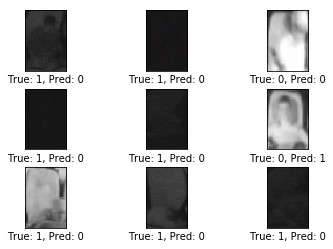

Confusion Matrix:
[[76746   111]
 [  342 18724]]


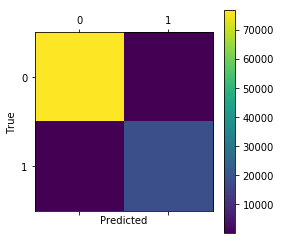

In [18]:
optimize(num_iterations=9000, early_stopping=True)

print_validation_accuracy(show_example_errors=True, show_confusion_matrix=True)

In [19]:
session.close()